In [2]:
"""Import everything we need and check gpu"""

%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import scipy.io as IO
import keras.backend as K
import keras.optimizers as optimizers
import os
from matplotlib import image
from keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
from cycler import cycler
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import colors


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

     |████████████████████████████████| 80 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 16.4 MB/s 
/bin/bash: nvidia-smi: command not found


In [3]:
"""Define the optics."""

IMAGE_SIZE = 1000
NUMBER_OF_PARTICLES = 8

particle = dt.MieSphere(
    position=lambda: SUB_IMAGE_SIZE//2 + (IMAGE_SIZE-SUB_IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -150 + np.random.random() * 300,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC# + CROP,         ###crop behaves strangely when IMAGE_SIZE is changed.
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: np.random.rand() * 0.01,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.01j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-6,
)

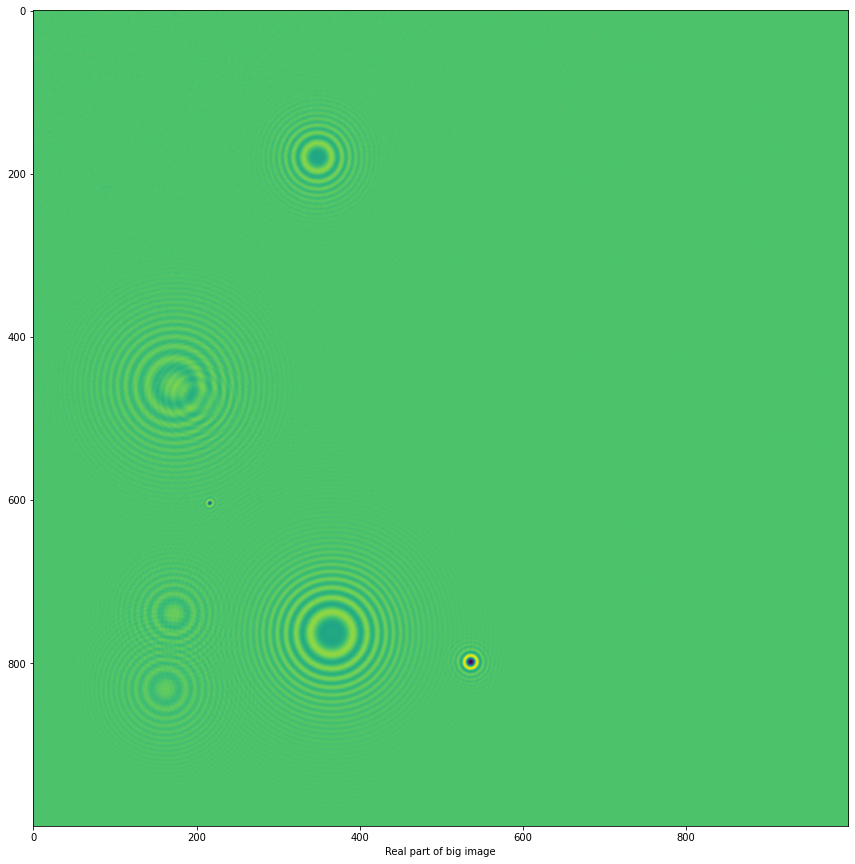

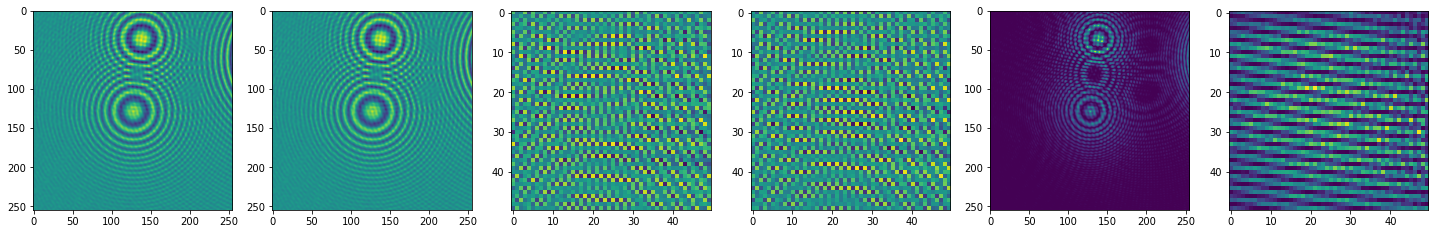

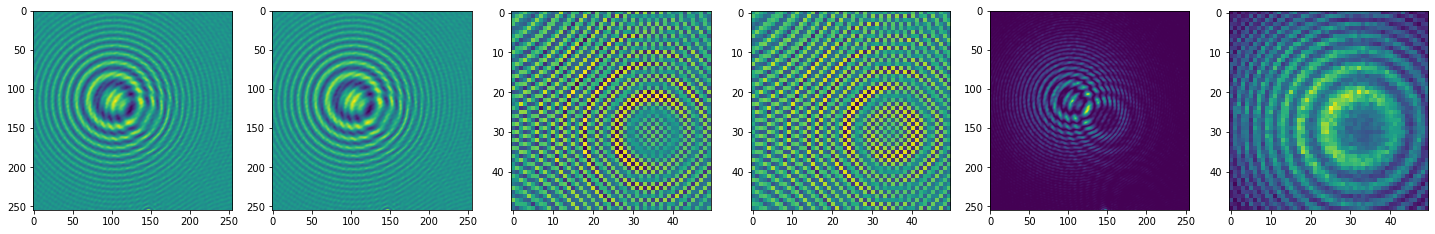

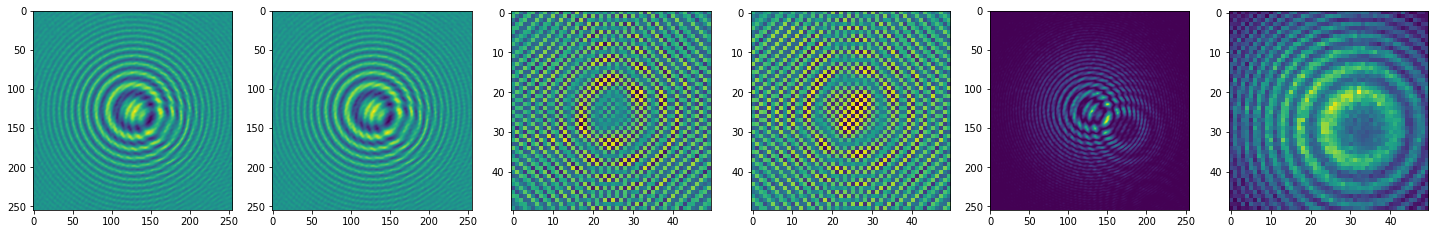

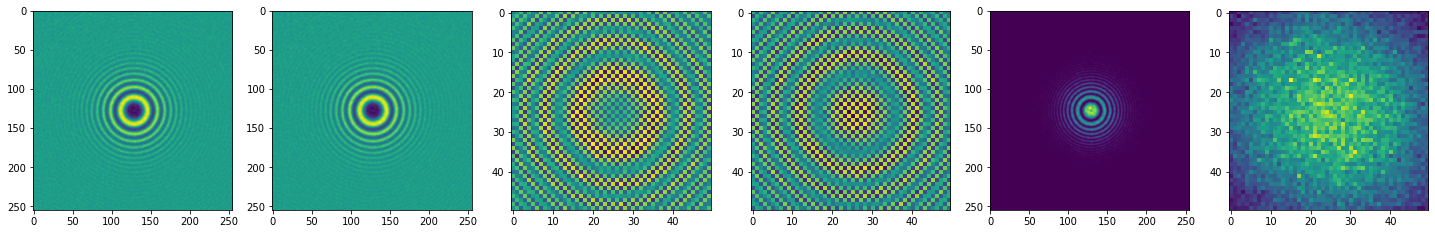

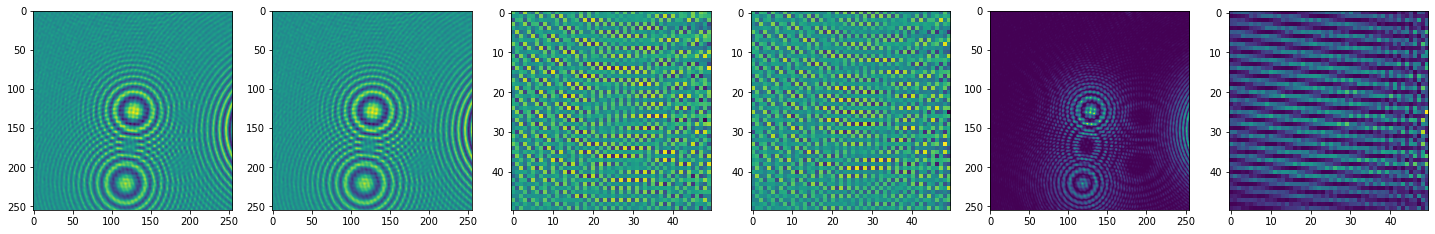

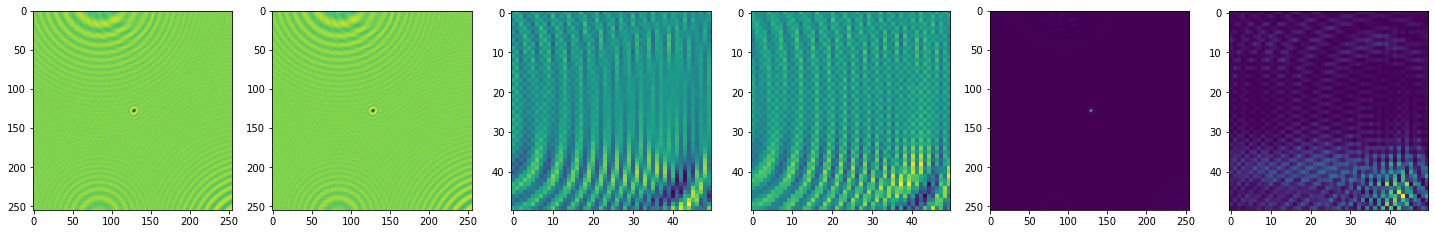

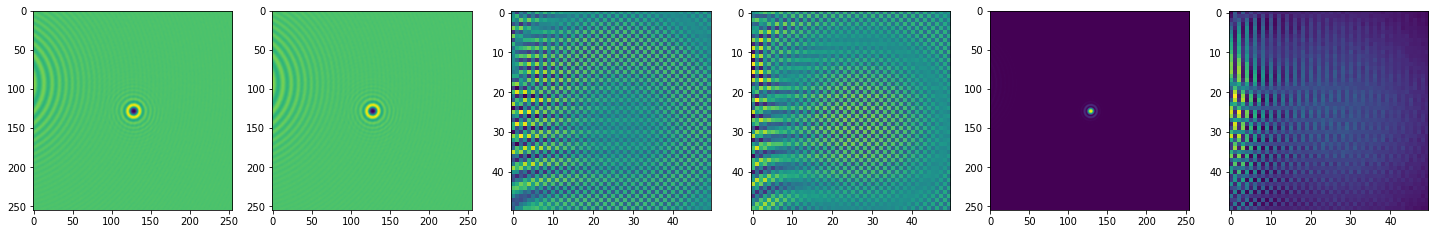

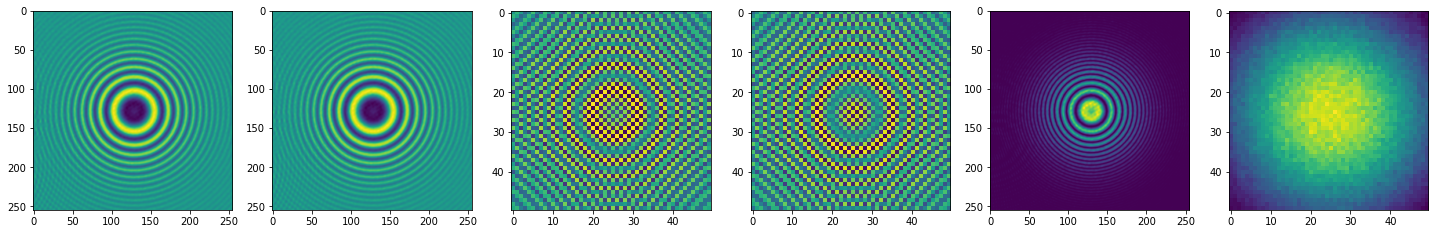

In [10]:
FOURIER_IMAGE_SIZE = 50
SUB_IMAGE_SIZE = 256

def crop_center(img, cropx, cropy):
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

def fourier_func():
    def inner(image):
        OUTDIM = 35
        output = np.zeros((OUTDIM, OUTDIM, 2))
        ft = fftshift(fft2(image[:,:,0]))
        output[:,:,0] = crop_center(np.imag(ft), OUTDIM, OUTDIM)
        output[:,:,1] = crop_center(np.real(ft), OUTDIM, OUTDIM)
        return output
    return inner

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

def normalization_func():
    def inner(image):
        output = np.zeros((*image.shape[:2], 2))
        output[:,:,0] = image[:,:,0] - np.min(image[:,:,0])
        output[:,:,1] = image[:,:,1] - np.min(image[:,:,1])
        return output
    return inner

def create_sub_images(image_of_particles, sub_image_size):
    positions = [property["position"] for property in image_of_particles.properties  if "position" in property]
    sub_images = []
    for point in positions:
        sub_image_row = np.arange( round(point[0]-sub_image_size[0]/2), round(point[0]+sub_image_size[0]/2))
        sub_image_column = np.arange(round(point[1]-sub_image_size[1]/2), round(point[1]+sub_image_size[1]/2))
        sub_images.append(image_of_particles[sub_image_row[0]:sub_image_row[-1],sub_image_column[0]:sub_image_column[-1]])
    return sub_images

complex_to_float = dt.Lambda(func)
fourier = dt.Lambda(fourier_func)
normalization = dt.Lambda(normalization_func)
particles = particle ** NUMBER_OF_PARTICLES
multiparticle_dataset = optics(particles + noise + gradient) + complex_to_float
test_image = multiparticle_dataset.update().resolve()

#Plotting the sub-images of all the particles.
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(test_image[:,:,0])
ax.set_xlabel("Real part of big image")
plt.show()

sub_images = create_sub_images(test_image, (SUB_IMAGE_SIZE, SUB_IMAGE_SIZE))
for img in sub_images:
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(25,8))
    ax1.imshow(img[:,:,0])
    ax2.imshow(img[:,:,0])
    ft = fftshift(fft2(img[:,:,0]+1j*img[:,:,1])-np.mean(img[:,:,0]+1j*img[:,:,1]))
    ax3.imshow(crop_center(np.real(ft), FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE))
    ax4.imshow(crop_center(np.imag(ft), FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE))
    ax5.imshow(np.abs(img[:,:,0])**2)
    ax6.imshow(crop_center(np.abs(ft)**2, FOURIER_IMAGE_SIZE, FOURIER_IMAGE_SIZE))
    plt.show()